In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.utils import tight_bbox, parse_lipid
from src.plots import plot_quant_vs_ogtt, set_square_ratio

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks'

import importlib
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from statsmodels.api import formula as smf

In [129]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

cd = pd.read_excel('../data/raw/metabolomics/validation/Nilerat_validation_metabs.xlsx')

## Map CD's long column name to short col name

In [141]:
cols = cd.filter(regex='^Area: ').columns
split_cols = [col.split(' ')[1][:-4] for col in cols]
split_cols
rename = {col: new for col, new in zip(cols, split_cols) if new in fg['File Name_metab'].values}
rename2 = {}
for key, value in rename.items():
    short = fg.loc[fg['File Name_metab'] == value].index[0]
#     print(short)
    rename2[key] = short
rename2
cd.rename(rename2, axis=1, inplace=True)
cd

,ID,in_original,is_lipid,is_junk,is_dubious,Annot. DeltaMass [ppm],Calc. MW,m/z,RT,adduct,...,Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC50uL_dil.raw (F65),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC100uL_dil.raw (F66),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep1.raw (F67),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep2.raw (F68),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep3.raw (F69),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC100uL_rep4.raw (F70),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC150uL_dil.raw (F71),Peak Rating: BJA-Nilerat-20220921_metab_1000s_QC200uL_dil.raw (F72),Peak Rating: BJA-Nilerat-20220921_metab_1000s_water_blank_rep1.raw (F73),Peak Rating: BJA-Nilerat-20220921_metab_resuspension_blank_rep1.raw (F92)
0,NaN,NaN,NaN,NaN,NaN,NaN,84.03107,83.02379,0.240,[M-H]-1,...,0.7,0.7,0.9,2.4,5.5,0.7,3.2,5.5,0.9,0.9
1,NaN,NaN,1.0,NaN,NaN,-4.18,510.33875,509.33147,1.300,[M-H]-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,1.0,NaN,NaN,-1.17,368.34387,369.35115,1.329,[M+H]+1,...,4.5,5.6,3.3,4.7,4.8,5.6,5.6,2.2,NaN,0.5
3,NaN,NaN,1.0,NaN,NaN,NaN,871.76122,872.76849,1.330,[M+H]+1,...,NaN,5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Cholesterol sulfate,NaN,1.0,NaN,NaN,1.63,466.31244,465.30516,1.389,[M-H]-1,...,3.6,0.9,6.2,5.5,5.8,3.9,3.9,5.1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,NaN,NaN,NaN,NaN,NaN,1.25,228.10861,227.10133,18.268,[M-H]-1,...,2.7,2.7,2.7,0.5,2.7,4.2,0.5,0.7,NaN,NaN
432,NaN,NaN,NaN,NaN,NaN,NaN,146.10463,145.09734,18.271,[M-H]-1,...,4.8,5.2,4.5,4.8,4.8,5.2,5.2,5.8,NaN,NaN
433,Arginine,1.0,NaN,NaN,NaN,-0.56,174.11158,175.11894,18.711,[M+H]+1,...,0.5,0.5,0.5,0.5,0.5,4.2,4.5,4.5,NaN,0.2
434,NaN,1.0,NaN,NaN,NaN,-8.00,132.08882,131.08154,18.724,[M-H]-1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


22

In [152]:
vdata = np.log2(cd.loc[:, rename2.values()])
extra_stuff = cd.iloc[:, :cd.columns.to_list().index('MS2')]
vdata = extra_stuff.join(vdata)
vdata


,ID,in_original,is_lipid,is_junk,is_dubious,Annot. DeltaMass [ppm],Calc. MW,m/z,RT,adduct,...,1700s_QC4,1700s_QC5,1700s_QC6,1700s_QC7,1700s_QC8,1700s_QCdil_150,1700s_QCdil_200,1700s_resuspension_blank_rep1,1700s_water_blank_rep1,1700s_water_blank_rep2
0,NaN,NaN,NaN,NaN,NaN,NaN,84.03107,83.02379,0.240,[M-H]-1,...,21.381361,30.017244,25.721532,25.620402,26.526276,25.970559,25.560817,19.676096,21.031353,18.918997
1,NaN,NaN,1.0,NaN,NaN,-4.18,510.33875,509.33147,1.300,[M-H]-1,...,22.712742,20.866109,21.180690,21.692261,21.718728,23.428032,23.053324,16.516584,17.025070,17.340864
2,NaN,NaN,1.0,NaN,NaN,-1.17,368.34387,369.35115,1.329,[M+H]+1,...,22.022570,20.215617,21.266970,21.382422,22.030310,21.456587,19.523454,15.675954,16.191938,16.417178
3,NaN,NaN,1.0,NaN,NaN,NaN,871.76122,872.76849,1.330,[M+H]+1,...,19.996507,18.798282,19.973698,20.627591,20.751220,20.457872,17.751225,15.997038,16.513023,16.738263
4,Cholesterol sulfate,NaN,1.0,NaN,NaN,1.63,466.31244,465.30516,1.389,[M-H]-1,...,27.291539,25.554985,25.679044,26.116711,26.342266,27.153465,26.319476,16.651364,17.242704,17.522161
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
431,NaN,NaN,NaN,NaN,NaN,1.25,228.10861,227.10133,18.268,[M-H]-1,...,19.757360,18.383321,20.464944,20.649165,20.683358,21.505963,21.755709,15.945249,15.908060,15.920376
432,NaN,NaN,NaN,NaN,NaN,NaN,146.10463,145.09734,18.271,[M-H]-1,...,22.053287,21.295241,22.622541,22.425076,22.416959,23.269041,23.642443,17.672595,15.483705,17.999694
433,Arginine,1.0,NaN,NaN,NaN,-0.56,174.11158,175.11894,18.711,[M+H]+1,...,24.344776,23.971925,23.088730,22.614651,22.621704,24.661192,25.188921,20.291128,16.736492,21.732980
434,NaN,1.0,NaN,NaN,NaN,-8.00,132.08882,131.08154,18.724,[M-H]-1,...,20.362964,20.444197,20.644126,19.858949,20.152270,21.422806,21.917545,15.116739,14.586511,18.663467


In [159]:
vdata.loc[vdata['ID'].str.lower().isin(oids['ID'].str.lower().to_list())]

,ID,in_original,is_lipid,is_junk,is_dubious,Annot. DeltaMass [ppm],Calc. MW,m/z,RT,adduct,...,1700s_QC4,1700s_QC5,1700s_QC6,1700s_QC7,1700s_QC8,1700s_QCdil_150,1700s_QCdil_200,1700s_resuspension_blank_rep1,1700s_water_blank_rep1,1700s_water_blank_rep2
107,Hydrocinnamic acid,1.0,NaN,NaN,NaN,-5.63,150.06724,149.05996,2.986,[M-H]-1,...,25.052492,22.627449,23.412625,23.393629,23.692646,24.804836,25.293154,16.753502,18.151200,17.393839
114,Creatinine,1.0,NaN,NaN,NaN,1.95,113.05913,114.06641,6.516,[M+H]+1,...,22.948845,22.526279,22.642687,22.726460,22.865178,23.419847,23.443868,16.764472,16.849806,19.381031
137,Betaine,1.0,NaN,NaN,NaN,1.46,117.07915,118.08643,8.482,[M+H]+1,...,27.236517,26.293717,26.522535,26.691040,26.823147,27.708015,27.877153,24.281384,23.295005,23.113751
147,Phenylalanine,NaN,NaN,NaN,NaN,-2.89,165.07850,164.07097,8.971,[M-H]-1,...,22.858415,22.189685,22.462813,22.581576,22.574252,23.541461,23.850405,15.397473,14.671410,17.248777
150,Trigonelline,1.0,NaN,NaN,NaN,-0.07,137.04767,138.05494,9.060,[M+H]+1,...,22.836662,22.216213,22.223546,22.490110,22.482166,23.517457,23.805292,16.285260,15.730364,19.512007
157,Tryptophan,1.0,NaN,NaN,NaN,-1.68,204.08953,203.08226,9.854,[M-H]-1,...,22.409711,21.915433,21.887581,21.888782,22.016645,22.871685,23.181987,15.485180,14.670393,18.707752
158,Indole-3-acrylic acid,1.0,NaN,NaN,NaN,-0.68,187.06320,188.07052,9.859,[M+H]+1,...,22.363175,21.977918,21.978081,21.980629,22.069199,22.974571,23.308867,14.856631,15.529498,19.590078
161,Lactic acid,1.0,NaN,NaN,NaN,-13.87,90.03045,89.02317,9.956,[M-H]-1,...,26.238478,25.706300,25.805088,25.816657,25.905211,26.771106,26.923447,24.006495,22.141386,22.753397
165,Proline,1.0,NaN,NaN,NaN,1.81,115.06354,116.07081,10.079,[M+H]+1,...,22.865155,22.728547,22.495599,22.523008,22.600508,23.413775,23.738443,19.721402,19.718702,19.706014
168,Acetyl-β-methylcholine,1.0,NaN,NaN,NaN,-0.46,159.12586,160.13313,10.398,[M+H]+1,...,20.851698,20.421176,20.302085,20.178575,20.343444,21.490136,21.722711,16.413153,17.296017,19.860267


In [155]:
oids = data.loc[(data['Type'] == 'metabolite') & (data['ID'] != 'Unidentified')]
oids

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,log_qval_sampling,log_qval_ogtt,log_qval_sampling:ogtt,is_id,lipid_class,extra_lipid_label,fa_carbons,fa_unsat,fa_carbon:unsat,pval_asterisks
i,,,,,,,,,,,,,,,,,,,,,
m_2,Urocanic acid_11.365_139.0503,Urocanic acid,139.05028,11.365,Nitrogen heterocycle,metabolite,+,HILIC,Nitrogen heterocycle,24.180859,...,0.748819,0.233844,0.104163,True,NaN,NaN,NaN,NaN,NaN,ns
m_3,Uridine_7.513_243.0615,Uridine,243.06152,7.513,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,24.887680,...,9.482876,0.889251,0.159312,True,NaN,NaN,NaN,NaN,NaN,ns
m_4,Uric acid_12.732_167.0201,Uric acid,167.02007,12.732,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,27.518513,...,0.459055,1.250723,0.480416,True,NaN,NaN,NaN,NaN,NaN,ns
m_5,Tyrosine_11.137_180.0656,Tyrosine,180.06563,11.137,Amino acid,metabolite,-,HILIC,Amino acid,23.065294,...,2.977319,1.403552,0.104163,True,NaN,NaN,NaN,NaN,NaN,ns
m_6,Tryptophan_9.861_203.0817,Tryptophan,203.08170,9.861,Amino acid,metabolite,-,HILIC,Amino acid,22.586018,...,3.488614,0.752468,0.268424,True,NaN,NaN,NaN,NaN,NaN,ns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_135,3-Indoxyl sulphate_8.177_212.0014,3-Indoxyl sulphate,212.00143,8.177,Organic acid,metabolite,-,HILIC,Organic acid,20.507605,...,1.286151,0.840874,0.921479,True,NaN,NaN,NaN,NaN,NaN,ns
m_136,3-Hydroxybutyric acid_9.527_103.0389,3-Hydroxybutyric acid,103.03895,9.527,Organic acid,metabolite,-,HILIC,Organic acid,26.065942,...,11.916771,0.272466,1.769866,True,NaN,NaN,NaN,NaN,NaN,*
m_138,2-Naphthalenesulfonic acid_3.845_207.0112,2-Naphthalenesulfonic acid,207.01125,3.845,Organic acid,metabolite,-,HILIC,Organic acid,22.362926,...,0.590490,2.504204,0.274634,True,NaN,NaN,NaN,NaN,NaN,ns


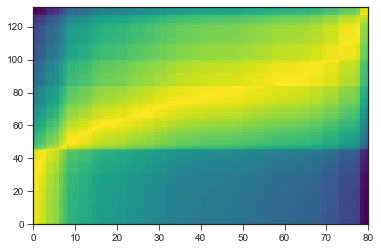

In [32]:
v_rt = vids['RT [min]'].sort_values().values
o_rt = oids['RT'].sort_values().values

rt_diffs = abs(np.subtract.outer(v_rt, o_rt))

plt.pcolormesh(rt_diffs, cmap='viridis_r')

In [ ]:
for o, orow in oids.iterrows():
    for v, vrow in vids.iterrows():
        print(abs())

In [153]:
oids[['ID', 'RT', 'm/z']].sort_values('ID').to_clipboard()

## Parse columns

In [81]:
# cols = cd.filter(regex='^Area: ')
# for col in cols: 
#     if 'wk' in col: 
#         split = col.split('_')
#         animal = split[2][:-1]
#         sex = split[2][-1]
#         week = int(split[3][:-2])
#         long_name = col.split(' ')[1][:-4]
#         short_name = f'{animal}_{week}_RBG' 
#         fg.loc[short_name, 'File Name_metab'] = long_name
#     else:
#         print(col)

## Parse run order

In [119]:
# order = {}
# existing_files = fg.loc[fg['validation'], 'File Name_metab'].dropna().values
# for file in Path('../data/raw/metabolomics/raw files').glob('*.raw'):
#     if 'BJA' not in str(file):
#         continue
# #     print(file.stat().st_mtime)
# #     print(file.stem)
#     order[file.stem] = file.stat().st_mtime
# order = pd.Series(order).sort_values().rank().to_frame().reset_index()
# order = order.loc[order['index'].isin(existing_files)]
# order[0] = order[0].rank()
# order.index = order['index']
# order.loc[existing_files, 0].to_clipboard()
# # (order.values[1:] - order.values[:-1])/60
